# Simple how to guide for filtering with the butterworth filter.

Below I load in a bunch of things, if this breaks just comment out that line, I think we really only need numpy and h5py

In [2]:
%reload_ext autoreload
%autoreload 2

import matplotlib
#import scipy
import numpy as np
import matplotlib.pyplot as plt

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import matplotlib # for some reason on the computer I am using I had to do this twice for it to display, weird bug
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Some useful definitions

M_FoV       = 64.    # field of view in units of GM/c^2 (these units only make sense for blakc holes, these definitions will need to be updated for this to work)
pad         = 4      # factor by which we will pad so we don't have aliasing when taking fft
distance    = 16800. # distance to the source in units of kpc
mass        = 6.5*10**9 # mass of M87 in units of solar mass
x           = 512    # number of pixels in each direction in the images
uvpix       = distance/(M_FoV*mass*pad)*2.09*10**7 # size of each pixel in Glambda when we take the fft








In [3]:
print(uvpix)

0.21100961538461538


Below I load in my library so that I can make pretty plots. I don't remember if I sent this to you or not, but even if I did the cell below will break because the path would be wrong. I recommend keeping this notebook for reference and trying it yourself in a separate notebook where you can load my library or plot the images however you want.

In [4]:
import sys
from os.path import expanduser
home = expanduser("~")
sys.path.append(home+'/Dropbox/research/master_code')
from my_plot import * # my module with some plotting functions

Functions below to open and save hdf5 files as an example, I think I sent these to you before. 

In [5]:
def save_hdf5(file_name, name, data):
    """!@brief Saves a hdf5 file.
    
    Very simple, just creates a hdf5 file.
    
    @param file_name the name of the file which will be created, should be a string.
    
    @param name the name given to the data in the file, the "key".
    
    @param data the actual data, probably a numpy array.
       
    @returns 0
    """
    import h5py
    h5f = h5py.File(file_name, 'w')
    h5f.create_dataset(name, data=data)
    h5f.close() 
    return(0)
    
    
def open_hdf5(file_name, mode='full', i=0):
    """!@brief Opens a hdf5 file.
    
    Very simple, just opens a hdf5 file.
    
    @param file_name the name of the file which will be opened, should be a string.
    
    @param mode optional keyword, default set to 'full', the possible options are:
        'full' which loads the full array
        'one' which loads one frame, the ith frame
        'range' which loads a range of frames from i[0] to i[1].
    
    @param i optional keyword, default set to 0, see mode above.
       
    @returns 0
    """ 
    import h5py
    file    = h5py.File(file_name, 'r') 
    name    = list(file.keys())[0]
    d       = file[str(name)] 
    if mode == 'full': result = d[:] 
    if mode == 'one':  result = d[i] 
    if mode == 'range':result = d[i[0]:i[1]]
    file.close()  
    return(result)

below is another function that will be used in the Butterworth filtering functions.

In [6]:
def padding2D(array, x0=0, y0=0, pad=8, type_complex=False):
    """!@brief Pads a 2D array by a factor pad.
    
    Makes a new array where each axis is pad times original size, 
    and then puts the original array in the center of this new big one. 
    The result will be the original array padded by many zeros on all sides.
    This function is used by myfft() and myfft_centered().
    
    @param array 2D numpy array.
     
    @param x0 optional keyword, default set to zero, if not set to zero 
    will offset the original array such that it is centered x0 away from 
    the center of the big array.
    
    @param y0 optional keyword, default set to zero, if not set to zero 
    will offset the original array such that it is centered y0 away from 
    the center of the big array.
    
    
    @param pad optional keyword, default set to 8. This is the factor by which 
    to pad the array before taking the fft.
    
    @param type_complex optional keyword, default set to False. If True, will 
    assume the input array is complex and return a complex array.
    
    @returns a 2D numpy array of floats, new array is pad times bigger 
    than original, and has original centered x0,y,0 away from the center.
    """
    ss = np.shape(array)
    if len(ss)==2:
        s = ss[0]
        padded = np.zeros((s*pad, s*pad))
        if type_complex==True: padded = np.array(padded,dtype=complex)
        padded[int(s*(pad-1)/2-y0): int(s*(pad+1)/2-y0), int(s*(pad-1)/2-x0): int(s*(pad+1)/2-x0)] = array
    elif len(ss)==3:
        s = ss[1]
        padded = np.zeros(((ss[0], s*pad, s*pad)))
        if type_complex==True: padded = np.array(padded,dtype=complex)
        padded[:, int(s*(pad-1)/2-y0): int(s*(pad+1)/2-y0), int(s*(pad-1)/2-x0): int(s*(pad+1)/2-x0)] = array
    return(padded)

In [5]:
def butterworth_filt(x,y,radius,n):
    """!@brief calculates kernel for Butterworth filter.
    
    Calculates the following equation
    
    \f[
    K = \frac{1}{\sqrt{1+(\sqrt{x^2+y^2}/R)^{2n}}}.
    \f]  
    for a given location in the image, this is used when making the mask for the Butterworth filter.
    See for example https://en.wikipedia.org/wiki/Butterworth_filter.
    
    @param x location in the x direction in the image.
    
    @param y location in the y direction in the image.
    
    @param radius radius of the Butterworth filter in units of pixels.
    
    @param n parameter for the Butterworth filter.
       
    @returns the result of the above equation.
    """
    return(1./(np.sqrt(1.+((np.sqrt(x*x+y*y)/radius)**(2.*n)))))

def mask_butterworth_filt(radius = 100, n=2,x=512):
    """!@brief creates the mask for the Butterworth filter.
    
    Calls butterworth_filt() for each location in a 2D array. 
    
    * Note that if you are planning to pad your images when you perform the convolution using 
    filter_image_padded() then you need to pad the mask as well so x should be x*pad where x 
    in this case is the size of your original images.
    
    @param radius opitional keyword, default set to 100, radius of the Butterworth filter in units of pixels.
    
    @param n optional keyword, default set to 2, parameter for the Butterworth filter.
    
    @param x number of pixels in each direction you want in the resulting 2D array.
       
    @returns the 2D numpy array containing the mask for the Butterworth filter.
    """
    mask_filt = np.zeros((x,x))
    for i in range(0,x):
        for j in range(0,x):
            ii = i-x/2
            jj = j-x/2
            mask_filt[i,j]=butterworth_filt(ii,jj,radius,n)
    return(mask_filt)

def filter_image_padded(image, mask, pad=4):
    """!@brief applies given mask to a given image. 

    Performs a convolution, multiplies the mask by the Fourier transform of the given image.

    @param image 2D numpy array containing the image you want to filter. 

    @param mask should be the result of the mask_butterworth_filt() function but should 
    have a size equal to the size of image multiplied by pad.

    @param pad optional keyword, default set to 4, this is the factor by which we pad so we 
    don't have aliasing when taking the Fourier transform

    @returns the 2D numpy array containing the mask for the Butterworth filter.
    """
    image = padding2D(image, pad=pad)
    mask  = padding2D(mask,  pad=pad)
    FT    = myfft(image,-1,pad=False)*mask
    image_filt = myifft(np.abs(FT),np.angle(FT),-1,pad=False)
    image_filt = unpad2D(np.abs(image_filt), pad=pad)
    return(image_filt)


Below I show you an example of how to use the code above. I load in an hdf5 file of a simulation in the example. It's a big file and I didn't want to try to email it to you, what I suggest is that you change the file name in the code below to one of the files I sent you and try this yourself.

In [25]:
cube = open_hdf5('hdf5/a9MAD_NE1e5_M6.5e9_R1_1.3mm.h5')

In [2]:
# get image 
which = 0 # set this to the index of the image you want in the cube you loaded.
image = cube[which,:,:]
image = image/np.sum(image)*6000 # the factor of 6000 is just a normalization, this makes all of the example images have the same total flux. 
plot_image(image, zoom=False, norm=False)

NameError: name 'cube' is not defined

Below I show an example of how to filter the image above using the parameters that we determined were good in the pixels paper, this is not the filter that is comparable to the filter that was used for the M87 images, it will be way less blurry than that. See the pixels paper for details https://arxiv.org/pdf/2004.06210.pdf.

It is important to understand why I make the mask separately from the convolution. Making the mask is computationally expensive, usually we want to apply the same mask to several different images so you should make the mask once and apply it to all of the images.

Below we make the mask, a radius of 65 pixels corresponds to 65*uvpix=13.72G lambda, for 15Glambda use radius=71. 

You will need to recalculate this based on your field of view, the baselines the instrument is sensitive to at the wavelength you're interested in, and the number of pixels in your images. See also the definitions in the very first code cell of this notebook.

In [6]:
mask_butter = mask_butterworth_filt(radius=65, n=2,x=x*pad) 

In [7]:
print(mask_butter.shape)

(2048, 2048)


<AxesSubplot:xlabel='X ($GMc^{-2}$)', ylabel='Y ($GMc^{-2}$)'>

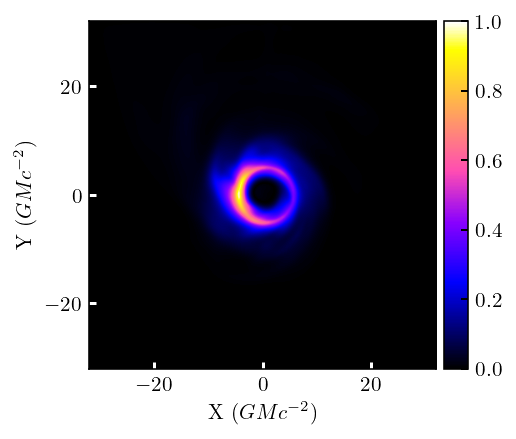

In [13]:
# here we apply the mask we made to the image and plot it. 
image_filt1 = filter_image_padded(image, mask_butter, pad=pad)

image_filt1 = image_filt1/np.sum(image_filt1)*6000 # the factor of 6000 is just a normalization, it't not necessary
plot_image(image_filt1, zoom=False, norm=False)

If you want to make the filter similar to what the M87 images look like you want to use a beam of about 8Glambda, this corresponds to about 38 pixels, 38*uvpix=8.02.

In [14]:
mask_butter2 = mask_butterworth_filt(radius=38, n=2,x=x*pad) 

<AxesSubplot:xlabel='X ($GMc^{-2}$)', ylabel='Y ($GMc^{-2}$)'>

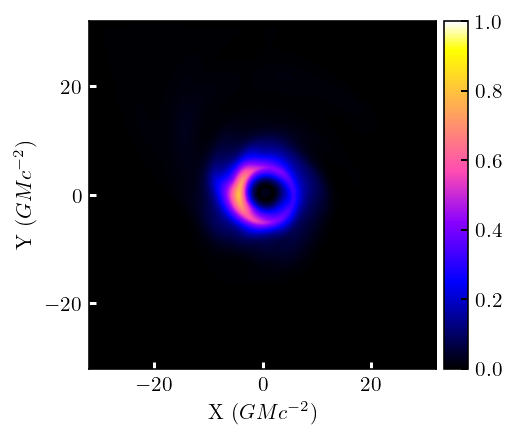

In [15]:
# here we apply the mask we made to the image and plot it. 
image_filt2 = filter_image_padded(image, mask_butter2, pad=pad)

image_filt2 = image_filt2/np.sum(image_filt2)*6000 # the factor of 6000 is just a normalization, it't not necessary
plot_image(image_filt2, zoom=False, norm=False)

In [16]:
test = open_hdf5('hdf5/a9MAD_NE1e5_M6.5e9_R20_1.3mm_191.h5')

<AxesSubplot:xlabel='X ($GMc^{-2}$)', ylabel='Y ($GMc^{-2}$)'>

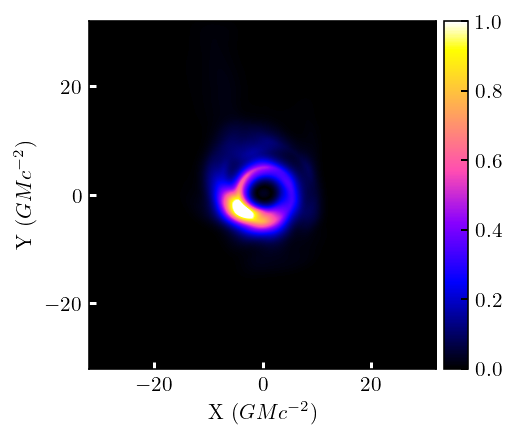

In [17]:
image_filt2 = filter_image_padded(test, mask_butter2, pad=pad)
image_filt2 = image_filt2/np.sum(image_filt2)*6000 # the factor of 6000 is just a normalization, it't not necessary
plot_image(image_filt2, zoom=False, norm=False)

In [18]:
# save_hdf5('hdf5/a9MAD_NE1e5_M6.5e9_R20_1.3mm_191_BW8.h5', 'BW', image_filt2)

0

# Juvis ignore everything below this point, that was for another student

In [23]:
# For Jason's models: 

M_FoV       = 42.    # field of view in units of GM/c^2
pad         = 4      # factor by which we will pad so we don't have aliasing when taking fft
distance    = 8.3 # distance in units of kpc
mass        = 4*10**6 # mass of M87 in units of solar mass
x           = 512    # number of pixels in each direction
uvpix       = distance/(M_FoV*mass*pad)*2.09*10**7 # size of each pixel in Glambda when we take the fft

# If you want to make the filter similar to what the M87 images look like you want to use a beam of about 8Glambda, this corresponds to about 31 pixels, 31*uvpix=8.00.

In [20]:
31*uvpix

8.002336309523809

In [5]:
np.abs(15-71*uvpix), np.abs(15-72*uvpix)

(0.01831730769230866, 0.19269230769230816)

In [13]:
mask_butter3 = mask_butterworth_filt(radius=31, n=2,x=x*pad) 

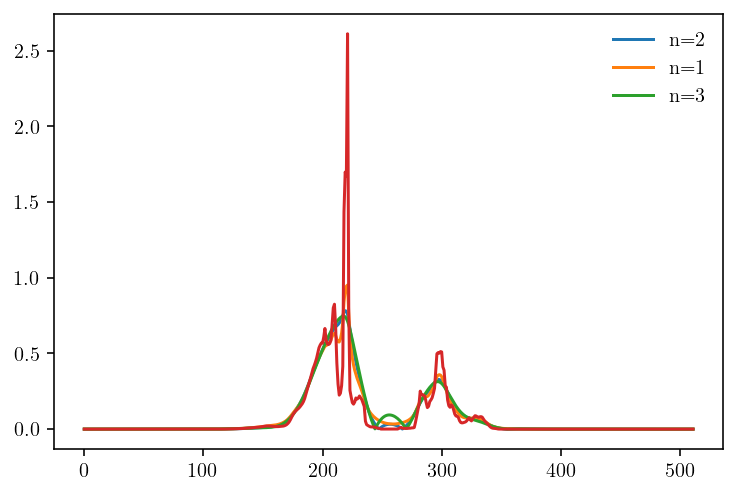

In [39]:
image_filt2 = filter_image_padded(test, mask_butter2, pad=pad)
image_filt2 = image_filt2/np.sum(image_filt2)*6000 # the factor of 6000 is just a normalization, it't not necessary
plt.plot(image_filt2[256,:], label='n=2')

image_filt1 = filter_image_padded(test, mask_butter1, pad=pad)
image_filt1 = image_filt1/np.sum(image_filt1)*6000 # the factor of 6000 is just a normalization, it't not necessary
plt.plot(image_filt1[256,:], label='n=1')

image_filt3 = filter_image_padded(test, mask_butter3, pad=pad)
image_filt3 = image_filt3/np.sum(image_filt3)*6000 # the factor of 6000 is just a normalization, it't not necessary
plt.plot(image_filt3[256,:], label='n=3')

plt.plot(test[256,:]/np.sum(test)*6000)

plt.legend(frameon=False)

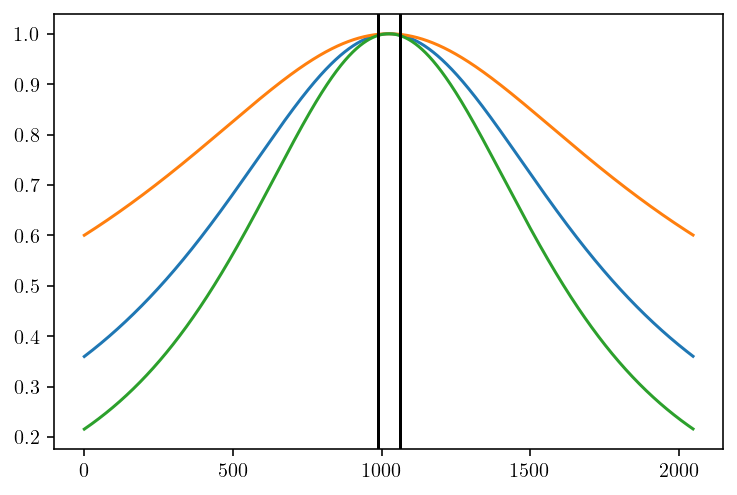

In [37]:
plt.plot(mask_butter2[256,:]/np.max(mask_butter2[256,:]))
plt.plot(mask_butter1[256,:]/np.max(mask_butter1[256,:]))
plt.plot(mask_butter3[256,:]/np.max(mask_butter3[256,:]))
plt.axvline(x=(256*pad)-38, c='k')
plt.axvline(x=(256*pad)+38, c='k')

In [21]:
def filter_image_padded(image, mask, pad=4):
    """!@brief applies given mask to a given image. 
    
    Performs a convolution, multiplies the mask by the Fourier transform of the given image.
    
    @param image 2D numpy array containing the image you want to filter. 
    
    @param mask should be the result of the mask_butterworth_filt() function but should 
    have a size equal to the size of image multiplied by pad.
    
    @param pad optional keyword, default set to 4, this is the factor by which we pad so we 
    don't have aliasing when taking the Fourier transform
       
    @returns the 2D numpy array containing the mask for the Butterworth filter.
    """
    image = padding2D(image, pad=pad)
#     mask  = padding2D(mask,  pad=pad)
    FT    = myfft(image,-1,pad=False)*mask
    image_filt = myifft(np.abs(FT),np.angle(FT),-1,pad=False)
    image_filt = unpad2D((image_filt), pad=pad)
    return(image_filt)

In [15]:
array_test = np.random.rand(512,512)

In [16]:
array_test = array_test-.5

In [22]:
new = filter_image_padded(array_test, mask_butter3, pad=4)

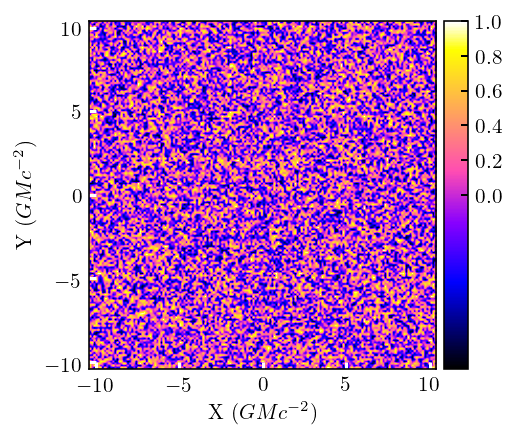

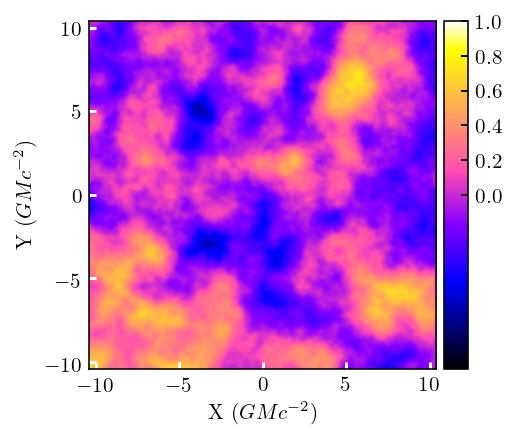

In [24]:
plot_image(array_test, lim_lin=np.array([-1,1]))
plot_image(np.real(new), lim_lin=np.array([-1,1]))

In [30]:
which = 0 # set this to the index of the image you want in the cube you loaded.
image = cube[which,:,:]
image = image/(np.max(image))-.1

In [31]:
new_image = filter_image_padded(image, mask_butter3, pad=4)

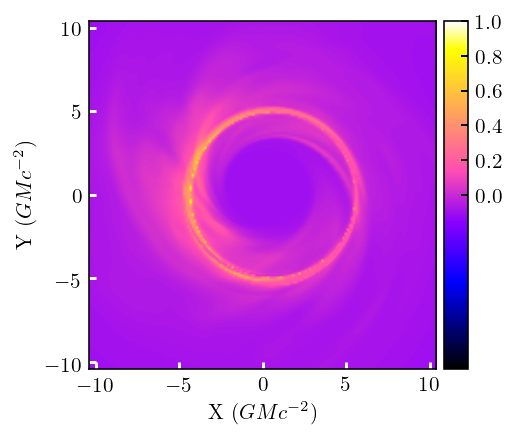

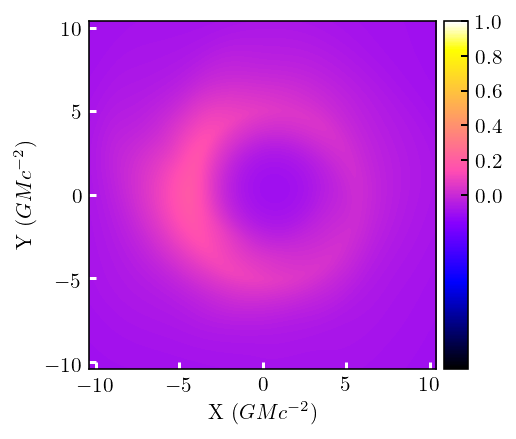

In [33]:
plot_image(image, lim_lin=np.array([-1,1]), norm=False)
plot_image(np.real(new_image), lim_lin=np.array([-1,1]), norm=False)

In [29]:
new_image

array([[-0.1395136 +3.75970876e-18j, -0.15350028+3.55431622e-18j,
        -0.16613638-3.75853598e-18j, ..., -0.16613723-2.11554329e-17j,
        -0.15350109+1.51707153e-17j, -0.13951436+3.08667975e-18j],
       [-0.15350027-9.55330242e-19j, -0.16927768+4.79919839e-18j,
        -0.18336215-1.11126222e-17j, ..., -0.18336308-5.01726320e-17j,
        -0.16927856-6.63714212e-19j, -0.15350109-7.00709491e-19j],
       [-0.16613637-1.95384201e-18j, -0.18336214-1.60466804e-17j,
        -0.1987311 -1.88820970e-17j, ..., -0.1987321 -2.11443265e-17j,
        -0.18336309+1.79040819e-18j, -0.16613724-2.30461417e-18j],
       ...,
       [-0.16577233+2.11109160e-17j, -0.18295704-3.60918536e-17j,
        -0.19828795-3.00788725e-17j, ..., -0.19856821-8.22660343e-19j,
        -0.18321191-1.17394472e-17j, -0.16600026+5.00372211e-18j],
       [-0.15316357+1.74418639e-17j, -0.16890329-2.43711172e-17j,
        -0.18295283+6.72177037e-18j, ..., -0.18321166+1.44244071e-18j,
        -0.1691388 +5.78854246e-19j